# Testing a superfast way to create huge graphs (aka SuperOnion)

SuperOnion uses encodings of values per column if they aren't numerical, to allow a more efficient way of loading bulk additions to graph-tool via numpy and the add_edge_list method.

This notebook tests it to see how it scales to millions of nodes, with many different types of node or edge properties, and missing values.

Some things that are _not_ yet accounted for:
- nested properties (e.g. 'ABC|XYZ')

The approximate results from the tests here (not replicated or tried on different machines, but ballpark):
- medium run: 12 seconds
  - 1m nodes, 5m edges, 12 node properties per node (layer, node_id, and 10 others: 5 ints, 3 floats, 2 categoricals), 10 edge properties per edge (also 5 ints, 3 floats, 2 categoricals)
- large run: 95 seconds
  - 10m nodes, 20m edges, 12 node properties per node (layer, node_id, and 10 others: 5 ints, 3 floats, 2 categoricals), 10 edge properties per edge (also 5 ints, 3 floats, 2 categoricals)

In [1]:
import lipinet.databases  # Import the module
import graph_tool as gt
import importlib

# Reload the module to ensure changes are picked up
importlib.reload(lipinet)

# Now you can use your function after reloading the module
from lipinet.databases import download_and_load_data, get_prior_knowledge
from lipinet.network import MultilayerNetwork, MultilayerNetworkGraphTool, MultilayerNetworkFast, MultilayerNetworkSuperFast
from lipinet.supernetwork import SuperOnion
from lipinet.visualisation import set_node_sizes_and_text_by_depth

import pandas as pd
import numpy as np

import graph_tool
from graph_tool.all import graph_draw, bfs_iterator

In [2]:
def run_scaleup_test(df_nodes, df_edges, onion_object, 
                     node_prop_cols=['node_prop_1', 'node_prop_2'], 
                     edge_prop_cols=['edge_prop_1', 'edge_prop_2'],
                     drop_na=True):

    # Show snippet of the data and shape
    for df in [df_nodes, df_edges]:
        display(df.head())
        print(df.shape)    


    # Add vertices from the DataFrame
    onion_object.add_vertices_from_dataframe(
        df_nodes,
        id_col='node_id',      # Original node IDs (strings)
        layer_col='layer',     # Original layer names (strings)
        property_cols=node_prop_cols,
        drop_na=drop_na           # Drop rows with missing IDs or layers
    )

    # Add edges from the DataFrame
    onion_object.add_edges_from_dataframe(
        df_edges,
        source_id_col='source_id',
        source_layer_col='source_layer',
        target_id_col='target_id',
        target_layer_col='target_layer',
        property_cols=edge_prop_cols,
        drop_na=drop_na
    )

    # Display graph summary
    summary_info = onion_object.summary()
    print("\nGraph Summary:")
    for key, value in summary_info.items():
        if isinstance(value, list):
            print(f"{key}:")
            for item in value:
                print(f"  - {item}")
        else:
            print(f"{key}: {value}")

    # List all vertex properties
    vertex_props_df = onion_object.list_vertex_properties()
    print("\nVertex Properties:")
    print(vertex_props_df)

    # List all edge properties
    edge_props_df = onion_object.list_edge_properties()
    print("\nEdge Properties:")
    print(edge_props_df)

    # View properties of a specific node 
    node_properties = onion_object.view_node_properties_by_names('LayerA', '1', verbose=True)

    # Retrieve an edge property 
    edge_prop_value = onion_object.get_edge_property_by_names('LayerA', '1', 'LayerB', '2', 'edge_prop_1', verbose=True)

    # Retrieve all edge properties between two nodes
    all_edge_props = onion_object.get_edge_property_by_names('LayerA', '1', 'LayerB', '2', verbose=True)


## Small Test

In [3]:
# Sample data for nodes
node_data = {
    'node_id': ['1', '2', '3'],          # String IDs
    'layer': ['LayerA', 'LayerB', 'LayerA'],  # String layers
    'node_prop_1': [10.5, 20.3, 30.1],   # Numerical properties (float)
    'node_prop_2': [100, 200, 300]        # Numerical properties (int)
}
df_nodes_small = pd.DataFrame(node_data)

# Sample data for edges
edge_data = {
    'source_id': ['1', '2'],              # String IDs
    'source_layer': ['LayerA', 'LayerB'], # String layers
    'target_id': ['2', '3'],              # String IDs
    'target_layer': ['LayerB', 'LayerA'], # String layers
    'edge_prop_1': [1.1, 2.2],            # Numerical properties (float)
    'edge_prop_2': [10, 20]                # Numerical properties (int)
}
df_edges_small = pd.DataFrame(edge_data)

node_props = [item for item in df_nodes_small.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_small.columns if item.startswith('edge_prop')]

superonion_small = SuperOnion()

In [4]:
run_scaleup_test(df_nodes=df_nodes_small,
                 df_edges=df_edges_small,
                 onion_object=superonion_small,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2
0,1,LayerA,10.5,100
1,2,LayerB,20.3,200
2,3,LayerA,30.1,300


(3, 4)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2
0,1,LayerA,2,LayerB,1.1,10
1,2,LayerB,3,LayerA,2.2,20


(2, 6)

Graph Summary:
Number of Vertices: 3
Number of Edges: 2
Number of Vertex Properties: 4
Number of Edge Properties: 2
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
Edge Properties:
  - edge_prop_1
  - edge_prop_2

Vertex Properties:
  Property Name     Type
0    layer_hash  int64_t
1  node_id_hash  int64_t
2   node_prop_1   double
3   node_prop_2  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1   double
1   edge_prop_2  int32_t

Properties for node (Layer: 'LayerA', Node ID: '1'):
  layer_hash: 0
  node_id_hash: 0
  node_prop_1: 10.5
  node_prop_2: 100
  decoded_layer: LayerA
  decoded_node_id: 1

Edge Property 'edge_prop_1' between (LayerA, '1') and (LayerB, '2'): 1.1

All Edge Properties between (LayerA, '1') and (LayerB, '2'):
  edge_prop_1: 1.1
  edge_prop_2: 10


## Medium test

In [5]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph
import pickle

# ---------------------------
# Generate Test DataFrames
# ---------------------------

print("Generating Test DataFrames...")

# Set RNG seed for reproducibility
np.random.seed(42)  # Set the seed to a fixed integer

# Parameters
num_nodes = 1_000_000  # 1 million nodes
num_edges = 5_000_000  # 5 million edges
layers = ['Layer_A', 'Layer_B', 'Layer_C', 'Layer_D', 'Layer_E']
categories = ['Category_X', 'Category_Y', 'Category_Z']
node_property_cols = [f'node_prop_{i}' for i in range(1, 11)]  # node_prop_1 to node_prop_10
edge_property_cols = [f'edge_prop_{i}' for i in range(1, 11)]  # edge_prop_1 to edge_prop_10

# Generate node_ids
node_ids = np.array(['node{}'.format(i) for i in range(1, num_nodes + 1)])

# Assign layers to nodes
node_layers = np.random.choice(layers, size=num_nodes)

# Generate node properties
# Integer properties
node_prop_1 = np.random.randint(0, 1000, size=num_nodes).astype('int32')
node_prop_2 = np.random.randint(1000, 2000, size=num_nodes).astype('int32')
node_prop_3 = np.random.randint(2000, 3000, size=num_nodes).astype('int32')
node_prop_4 = np.random.randint(3000, 4000, size=num_nodes).astype('int32')
node_prop_5 = np.random.randint(4000, 5000, size=num_nodes).astype('int32')

# Float properties
node_prop_6 = np.random.uniform(0, 1000, size=num_nodes).astype('float32')
node_prop_7 = np.random.uniform(1000, 2000, size=num_nodes).astype('float32')
node_prop_8 = np.random.uniform(2000, 3000, size=num_nodes).astype('float32')

# Categorical properties
node_prop_9 = np.random.choice(categories, size=num_nodes)
node_prop_10 = np.random.choice(categories, size=num_nodes)

# Create nodes DataFrame
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': node_layers,
    'node_prop_1': node_prop_1,
    'node_prop_2': node_prop_2,
    'node_prop_3': node_prop_3,
    'node_prop_4': node_prop_4,
    'node_prop_5': node_prop_5,
    'node_prop_6': node_prop_6,
    'node_prop_7': node_prop_7,
    'node_prop_8': node_prop_8,
    'node_prop_9': node_prop_9,
    'node_prop_10': node_prop_10
})

# Optimize data types
df_nodes['node_id'] = df_nodes['node_id'].astype('category')
df_nodes['layer'] = df_nodes['layer'].astype('category')
df_nodes['node_prop_9'] = df_nodes['node_prop_9'].astype('category')
df_nodes['node_prop_10'] = df_nodes['node_prop_10'].astype('category')

df_nodes_medium = df_nodes # to standardise naming with previous test

print("Nodes DataFrame created with shape:", df_nodes_medium.shape)

# Generate edges
source_ids = np.random.choice(node_ids, size=num_edges)
target_ids = np.random.choice(node_ids, size=num_edges)

# Create mapping from node_id to layer
node_id_to_layer = pd.Series(df_nodes.layer.values, index=df_nodes.node_id).to_dict()

# Assign layers based on node IDs
edge_source_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in source_ids])
edge_target_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in target_ids])

# Generate edge properties
# Integer properties
edge_prop_1 = np.random.randint(0, 100, size=num_edges).astype('int16')
edge_prop_2 = np.random.randint(100, 200, size=num_edges).astype('int16')
edge_prop_3 = np.random.randint(200, 300, size=num_edges).astype('int16')
edge_prop_4 = np.random.randint(300, 400, size=num_edges).astype('int16')
edge_prop_5 = np.random.randint(400, 500, size=num_edges).astype('int16')

# Float properties
edge_prop_6 = np.random.uniform(0, 100, size=num_edges).astype('float32')
edge_prop_7 = np.random.uniform(100, 200, size=num_edges).astype('float32')
edge_prop_8 = np.random.uniform(200, 300, size=num_edges).astype('float32')

# Categorical properties
edge_prop_9 = np.random.choice(categories, size=num_edges)
edge_prop_10 = np.random.choice(categories, size=num_edges)

# Create edges DataFrame
df_edges = pd.DataFrame({
    'source_id': source_ids,
    'source_layer': edge_source_layers,
    'target_id': target_ids,
    'target_layer': edge_target_layers,
    'edge_prop_1': edge_prop_1,
    'edge_prop_2': edge_prop_2,
    'edge_prop_3': edge_prop_3,
    'edge_prop_4': edge_prop_4,
    'edge_prop_5': edge_prop_5,
    'edge_prop_6': edge_prop_6,
    'edge_prop_7': edge_prop_7,
    'edge_prop_8': edge_prop_8,
    'edge_prop_9': edge_prop_9,
    'edge_prop_10': edge_prop_10
})

# Optimize data types
df_edges['source_id'] = df_edges['source_id'].astype('category')
df_edges['source_layer'] = df_edges['source_layer'].astype('category')
df_edges['target_id'] = df_edges['target_id'].astype('category')
df_edges['target_layer'] = df_edges['target_layer'].astype('category')
df_edges['edge_prop_9'] = df_edges['edge_prop_9'].astype('category')
df_edges['edge_prop_10'] = df_edges['edge_prop_10'].astype('category')

df_edges_medium = df_edges # to standardise naming with previous test

print("Edges DataFrame created with shape:", df_edges_medium.shape)

# ---------------------------
# Add specific edges for testing
# ---------------------------

# # Define specific edges you want to ensure exist in the graph
# specific_edges = pd.DataFrame({
#     'source_id': ['node359928', 'node823610'],  # Replace with actual node IDs
#     'source_layer': ['Layer_D', 'Layer_A'],
#     'target_id': ['node128516', 'node798629'],
#     'target_layer': ['Layer_D', 'Layer_E'],
#     'edge_prop_1': [25, 30],  # Example property values
#     'edge_prop_2': [35, 40],
#     'edge_prop_3': [45, 50],
#     'edge_prop_4': [55, 60],
#     'edge_prop_5': [65, 70],
#     'edge_prop_6': [75.76, 80.80],
#     'edge_prop_7': [85.86, 90.90],
#     'edge_prop_8': [95.96, 100.100],
#     'edge_prop_9': ['Category_Z', 'Category_Y'],
#     'edge_prop_10': ['Category_X', 'Category_Z']
# })

# Optimize data types for specific_edges
# specific_edges['source_id'] = specific_edges['source_id'].astype('category')
# specific_edges['source_layer'] = specific_edges['source_layer'].astype('category')
# specific_edges['target_id'] = specific_edges['target_id'].astype('category')
# specific_edges['target_layer'] = specific_edges['target_layer'].astype('category')
# specific_edges['edge_prop_9'] = specific_edges['edge_prop_9'].astype('category')
# specific_edges['edge_prop_10'] = specific_edges['edge_prop_10'].astype('category')

# Append specific edges to the edges DataFrame
# df_edges = pd.concat([specific_edges, df_edges], ignore_index=True)

node_props = [item for item in df_nodes_medium.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_medium.columns if item.startswith('edge_prop')]

superonion_medium = SuperOnion()


Generating Test DataFrames...
Nodes DataFrame created with shape: (1000000, 12)
Edges DataFrame created with shape: (5000000, 14)


In [6]:
run_scaleup_test(df_nodes=df_nodes_medium,
                 df_edges=df_edges_medium,
                 onion_object=superonion_medium,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2,node_prop_3,node_prop_4,node_prop_5,node_prop_6,node_prop_7,node_prop_8,node_prop_9,node_prop_10
0,node1,Layer_D,284,1197,2874,3725,4703,858.844849,1805.748901,2187.844482,Category_X,Category_X
1,node2,Layer_E,430,1935,2388,3276,4325,756.825623,1347.896118,2316.397949,Category_Z,Category_X
2,node3,Layer_C,945,1212,2511,3574,4261,94.367973,1956.879883,2043.174927,Category_Y,Category_Y
3,node4,Layer_E,405,1977,2728,3287,4040,412.188324,1137.894409,2803.983154,Category_Y,Category_X
4,node5,Layer_E,739,1741,2052,3515,4850,969.274231,1349.678223,2627.374268,Category_Z,Category_Z


(1000000, 12)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2,edge_prop_3,edge_prop_4,edge_prop_5,edge_prop_6,edge_prop_7,edge_prop_8,edge_prop_9,edge_prop_10
0,node206252,Layer_A,node860662,Layer_A,99,156,207,315,436,48.851147,154.910324,214.405975,Category_Y,Category_Z
1,node639425,Layer_D,node509845,Layer_E,71,159,277,307,454,0.841779,146.617432,239.794128,Category_Y,Category_Z
2,node93648,Layer_C,node992976,Layer_D,19,128,208,371,456,29.605192,146.235992,200.754440,Category_Y,Category_X
3,node566658,Layer_C,node419108,Layer_E,47,149,253,379,483,2.823314,159.105331,200.614014,Category_Y,Category_Z
4,node512068,Layer_B,node822872,Layer_D,95,163,247,368,456,76.048004,101.035538,267.903137,Category_Z,Category_X


(5000000, 14)

Graph Summary:
Number of Vertices: 1000000
Number of Edges: 5000000
Number of Vertex Properties: 12
Number of Edge Properties: 10
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
  - node_prop_3
  - node_prop_4
  - node_prop_5
  - node_prop_6
  - node_prop_7
  - node_prop_8
  - node_prop_9
  - node_prop_10
Edge Properties:
  - edge_prop_1
  - edge_prop_2
  - edge_prop_3
  - edge_prop_4
  - edge_prop_5
  - edge_prop_6
  - edge_prop_7
  - edge_prop_8
  - edge_prop_9
  - edge_prop_10

Vertex Properties:
   Property Name     Type
0     layer_hash  int64_t
1   node_id_hash  int64_t
2    node_prop_1  int32_t
3    node_prop_2  int32_t
4    node_prop_3  int32_t
5    node_prop_4  int32_t
6    node_prop_5  int32_t
7    node_prop_6   double
8    node_prop_7   double
9    node_prop_8   double
10   node_prop_9  int32_t
11  node_prop_10  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1  int32_t
1   edge_prop_2  int32_t
2   edge_prop_

Could also view different specific nodes

In [7]:
# # ---------------------------
# # View properties of a specific node
# # ---------------------------

# # Example: View properties of node 'node1' in 'Layer_A'
# node_properties = graph.view_node_properties_by_names('Layer_D', 'node1', verbose=True)

# # ---------------------------
# # Retrieve a specific edge property
# # ---------------------------

# # Example: Retrieve 'edge_prop_1' between ('Layer_D', 'node359928') and ('Layer_D', 'node128516') with verbose output
# edge_prop_value = graph.get_edge_property_by_names(
#     source_layer_name='Layer_D',
#     source_node_id_str='node359928',
#     target_layer_name='Layer_D',
#     target_node_id_str='node128516',
#     prop_name='edge_prop_1',
#     verbose=True
# )

# # ---------------------------
# # Retrieve all edge properties between two nodes
# # ---------------------------

# # Example: Retrieve all edge properties between ('Layer_A', 'node823610') and ('Layer_E', 'node798629') with verbose output
# all_edge_props = graph.get_edge_property_by_names(
#     source_layer_name='Layer_A',
#     source_node_id_str='node823610',
#     target_layer_name='Layer_E',
#     target_node_id_str='node798629',
#     verbose=True
# )

## Large test

In [8]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph
import pickle

# ---------------------------
# Generate Test DataFrames
# ---------------------------

print("Generating Test DataFrames...")

# Set RNG seed for reproducibility
np.random.seed(42)  # Set the seed to a fixed integer

# Parameters
num_nodes = 10_000_000  # 10 million nodes
num_edges = 20_000_000  # 20 million edges
layers = ['Layer_A', 'Layer_B', 'Layer_C', 'Layer_D', 'Layer_E']
categories = ['Category_X', 'Category_Y', 'Category_Z']
node_property_cols = [f'node_prop_{i}' for i in range(1, 11)]  # node_prop_1 to node_prop_10
edge_property_cols = [f'edge_prop_{i}' for i in range(1, 11)]  # edge_prop_1 to edge_prop_10

# Generate node_ids
node_ids = np.array(['node{}'.format(i) for i in range(1, num_nodes + 1)])

# Assign layers to nodes
node_layers = np.random.choice(layers, size=num_nodes)

# Generate node properties
# Integer properties
node_prop_1 = np.random.randint(0, 1000, size=num_nodes).astype('int32')
node_prop_2 = np.random.randint(1000, 2000, size=num_nodes).astype('int32')
node_prop_3 = np.random.randint(2000, 3000, size=num_nodes).astype('int32')
node_prop_4 = np.random.randint(3000, 4000, size=num_nodes).astype('int32')
node_prop_5 = np.random.randint(4000, 5000, size=num_nodes).astype('int32')

# Float properties
node_prop_6 = np.random.uniform(0, 1000, size=num_nodes).astype('float32')
node_prop_7 = np.random.uniform(1000, 2000, size=num_nodes).astype('float32')
node_prop_8 = np.random.uniform(2000, 3000, size=num_nodes).astype('float32')

# Categorical properties
node_prop_9 = np.random.choice(categories, size=num_nodes)
node_prop_10 = np.random.choice(categories, size=num_nodes)

# Create nodes DataFrame
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': node_layers,
    'node_prop_1': node_prop_1,
    'node_prop_2': node_prop_2,
    'node_prop_3': node_prop_3,
    'node_prop_4': node_prop_4,
    'node_prop_5': node_prop_5,
    'node_prop_6': node_prop_6,
    'node_prop_7': node_prop_7,
    'node_prop_8': node_prop_8,
    'node_prop_9': node_prop_9,
    'node_prop_10': node_prop_10
})

# Optimize data types
df_nodes['node_id'] = df_nodes['node_id'].astype('category')
df_nodes['layer'] = df_nodes['layer'].astype('category')
df_nodes['node_prop_9'] = df_nodes['node_prop_9'].astype('category')
df_nodes['node_prop_10'] = df_nodes['node_prop_10'].astype('category')

df_nodes_large = df_nodes # to standardise naming with previous test

print("Nodes DataFrame created with shape:", df_nodes_large.shape)

# Generate edges
source_ids = np.random.choice(node_ids, size=num_edges)
target_ids = np.random.choice(node_ids, size=num_edges)

# Create mapping from node_id to layer
node_id_to_layer = pd.Series(df_nodes.layer.values, index=df_nodes.node_id).to_dict()

# Assign layers based on node IDs
edge_source_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in source_ids])
edge_target_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in target_ids])

# Generate edge properties
# Integer properties
edge_prop_1 = np.random.randint(0, 100, size=num_edges).astype('int16')
edge_prop_2 = np.random.randint(100, 200, size=num_edges).astype('int16')
edge_prop_3 = np.random.randint(200, 300, size=num_edges).astype('int16')
edge_prop_4 = np.random.randint(300, 400, size=num_edges).astype('int16')
edge_prop_5 = np.random.randint(400, 500, size=num_edges).astype('int16')

# Float properties
edge_prop_6 = np.random.uniform(0, 100, size=num_edges).astype('float32')
edge_prop_7 = np.random.uniform(100, 200, size=num_edges).astype('float32')
edge_prop_8 = np.random.uniform(200, 300, size=num_edges).astype('float32')

# Categorical properties
edge_prop_9 = np.random.choice(categories, size=num_edges)
edge_prop_10 = np.random.choice(categories, size=num_edges)

# Create edges DataFrame
df_edges = pd.DataFrame({
    'source_id': source_ids,
    'source_layer': edge_source_layers,
    'target_id': target_ids,
    'target_layer': edge_target_layers,
    'edge_prop_1': edge_prop_1,
    'edge_prop_2': edge_prop_2,
    'edge_prop_3': edge_prop_3,
    'edge_prop_4': edge_prop_4,
    'edge_prop_5': edge_prop_5,
    'edge_prop_6': edge_prop_6,
    'edge_prop_7': edge_prop_7,
    'edge_prop_8': edge_prop_8,
    'edge_prop_9': edge_prop_9,
    'edge_prop_10': edge_prop_10
})

# Optimize data types
df_edges['source_id'] = df_edges['source_id'].astype('category')
df_edges['source_layer'] = df_edges['source_layer'].astype('category')
df_edges['target_id'] = df_edges['target_id'].astype('category')
df_edges['target_layer'] = df_edges['target_layer'].astype('category')
df_edges['edge_prop_9'] = df_edges['edge_prop_9'].astype('category')
df_edges['edge_prop_10'] = df_edges['edge_prop_10'].astype('category')

df_edges_large = df_edges # to standardise naming with previous test

print("Edges DataFrame created with shape:", df_edges_large.shape)

# ---------------------------
# Add specific edges for testing
# ---------------------------

# # Define specific edges you want to ensure exist in the graph
# specific_edges = pd.DataFrame({
#     'source_id': ['node359928', 'node823610'],  # Replace with actual node IDs
#     'source_layer': ['Layer_D', 'Layer_A'],
#     'target_id': ['node128516', 'node798629'],
#     'target_layer': ['Layer_D', 'Layer_E'],
#     'edge_prop_1': [25, 30],  # Example property values
#     'edge_prop_2': [35, 40],
#     'edge_prop_3': [45, 50],
#     'edge_prop_4': [55, 60],
#     'edge_prop_5': [65, 70],
#     'edge_prop_6': [75.76, 80.80],
#     'edge_prop_7': [85.86, 90.90],
#     'edge_prop_8': [95.96, 100.100],
#     'edge_prop_9': ['Category_Z', 'Category_Y'],
#     'edge_prop_10': ['Category_X', 'Category_Z']
# })

# Optimize data types for specific_edges
# specific_edges['source_id'] = specific_edges['source_id'].astype('category')
# specific_edges['source_layer'] = specific_edges['source_layer'].astype('category')
# specific_edges['target_id'] = specific_edges['target_id'].astype('category')
# specific_edges['target_layer'] = specific_edges['target_layer'].astype('category')
# specific_edges['edge_prop_9'] = specific_edges['edge_prop_9'].astype('category')
# specific_edges['edge_prop_10'] = specific_edges['edge_prop_10'].astype('category')

# Append specific edges to the edges DataFrame
# df_edges = pd.concat([specific_edges, df_edges], ignore_index=True)

node_props = [item for item in df_nodes_large.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_large.columns if item.startswith('edge_prop')]

superonion_large = SuperOnion()


Generating Test DataFrames...
Nodes DataFrame created with shape: (10000000, 12)
Edges DataFrame created with shape: (20000000, 14)


In [9]:
run_scaleup_test(df_nodes=df_nodes_large,
                 df_edges=df_edges_large,
                 onion_object=superonion_large,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2,node_prop_3,node_prop_4,node_prop_5,node_prop_6,node_prop_7,node_prop_8,node_prop_9,node_prop_10
0,node1,Layer_D,296,1076,2401,3706,4436,848.054443,1539.280273,2859.425049,Category_X,Category_Y
1,node2,Layer_E,303,1946,2639,3695,4764,632.563965,1212.131958,2327.489990,Category_X,Category_Z
2,node3,Layer_C,789,1257,2784,3938,4625,119.896690,1467.985962,2779.227539,Category_X,Category_X
3,node4,Layer_E,700,1605,2632,3307,4717,410.072601,1357.623413,2671.763672,Category_Y,Category_Y
4,node5,Layer_E,272,1480,2598,3279,4773,110.029602,1774.444458,2991.134033,Category_X,Category_X


(10000000, 12)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2,edge_prop_3,edge_prop_4,edge_prop_5,edge_prop_6,edge_prop_7,edge_prop_8,edge_prop_9,edge_prop_10
0,node4030330,Layer_A,node9117879,Layer_B,6,152,235,323,449,76.915787,166.862640,277.870667,Category_Z,Category_Z
1,node3335458,Layer_D,node2385636,Layer_C,12,121,217,317,427,60.170994,113.132912,242.742599,Category_Y,Category_X
2,node8410171,Layer_E,node5804136,Layer_B,81,166,249,386,453,49.830536,139.739212,253.921097,Category_X,Category_Z
3,node1952666,Layer_B,node17359,Layer_C,95,139,296,342,486,88.998734,149.456314,255.178589,Category_Z,Category_Y
4,node8753006,Layer_D,node2246470,Layer_C,9,144,244,347,496,23.941750,139.505844,243.491013,Category_X,Category_Y


(20000000, 14)

Graph Summary:
Number of Vertices: 10000000
Number of Edges: 20000000
Number of Vertex Properties: 12
Number of Edge Properties: 10
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
  - node_prop_3
  - node_prop_4
  - node_prop_5
  - node_prop_6
  - node_prop_7
  - node_prop_8
  - node_prop_9
  - node_prop_10
Edge Properties:
  - edge_prop_1
  - edge_prop_2
  - edge_prop_3
  - edge_prop_4
  - edge_prop_5
  - edge_prop_6
  - edge_prop_7
  - edge_prop_8
  - edge_prop_9
  - edge_prop_10

Vertex Properties:
   Property Name     Type
0     layer_hash  int64_t
1   node_id_hash  int64_t
2    node_prop_1  int32_t
3    node_prop_2  int32_t
4    node_prop_3  int32_t
5    node_prop_4  int32_t
6    node_prop_5  int32_t
7    node_prop_6   double
8    node_prop_7   double
9    node_prop_8   double
10   node_prop_9  int32_t
11  node_prop_10  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1  int32_t
1   edge_prop_2  int32_t
2   edge_pr

Could also view different specific nodes

In [10]:
# # ---------------------------
# # View properties of a specific node
# # ---------------------------

# # Example: View properties of node 'node1' in 'Layer_A'
# node_properties = graph.view_node_properties_by_names('Layer_D', 'node1', verbose=True)

# # ---------------------------
# # Retrieve a specific edge property
# # ---------------------------

# # Example: Retrieve 'edge_prop_1' between ('Layer_D', 'node359928') and ('Layer_D', 'node128516') with verbose output
# edge_prop_value = graph.get_edge_property_by_names(
#     source_layer_name='Layer_D',
#     source_node_id_str='node359928',
#     target_layer_name='Layer_D',
#     target_node_id_str='node128516',
#     prop_name='edge_prop_1',
#     verbose=True
# )

# # ---------------------------
# # Retrieve all edge properties between two nodes
# # ---------------------------

# # Example: Retrieve all edge properties between ('Layer_A', 'node823610') and ('Layer_E', 'node798629') with verbose output
# all_edge_props = graph.get_edge_property_by_names(
#     source_layer_name='Layer_A',
#     source_node_id_str='node823610',
#     target_layer_name='Layer_E',
#     target_node_id_str='node798629',
#     verbose=True
# )

# Old code 

Keeping for now, in case we want to do a comparison to the other previous method

In [79]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph
from graph_tool.util import prop_set

class CustomIDGraph:
    def __init__(self, directed=True):
        self.graph = Graph(directed=directed)
        self.id_to_index = {}  # Map from custom ID tuple (layer, node_id) to vertex index
        self.index_to_id = {}  # Map from vertex index to custom ID tuple (layer, node_id)
        
        # Initialize vertex properties
        self.graph.vp['layer'] = self.graph.new_vertex_property('string')
        self.graph.vp['node_id'] = self.graph.new_vertex_property('string')
        
        # Initialize other vertex properties as needed (they will be added dynamically)

    def _infer_property_type(self, value):
        """
        Infer the property type based on the value.
        """
        if isinstance(value, float):
            return 'float'
        elif isinstance(value, int):
            return 'int'
        elif isinstance(value, str):
            return 'string'
        else:
            return 'object'  # Use 'object' for any other type

    def add_vertices_from_dataframe(self, df_nodes, id_col, layer_col, property_cols=None, drop_na=True, fill_na_with=None):
        """
        Add vertices from a DataFrame with custom IDs and properties.
        """
        # Handle missing values
        if drop_na:
            df_nodes = df_nodes.dropna(subset=[id_col, layer_col])
        else:
            df_nodes = df_nodes.fillna({id_col: fill_na_with, layer_col: fill_na_with})

        # Ensure all components are strings
        df_nodes[id_col] = df_nodes[id_col].astype(str)
        df_nodes[layer_col] = df_nodes[layer_col].astype(str)

        # Create custom ID tuples
        custom_ids = list(zip(df_nodes[layer_col], df_nodes[id_col]))
        n_new_vertices = len(custom_ids)
        starting_index = self.graph.num_vertices()
        self.graph.add_vertex(n_new_vertices)

        # Update mapping dictionaries
        new_indices = np.arange(starting_index, starting_index + n_new_vertices, dtype=np.int64)
        self.id_to_index.update(zip(custom_ids, new_indices))
        self.index_to_id.update(zip(new_indices, custom_ids))

        # Create an array of new vertex descriptors
        new_vertices = [self.graph.vertex(i) for i in new_indices]

        # Convert to fixed-length Unicode strings (adjust 'U50' as needed)
        layer_values = df_nodes[layer_col].values.astype('U50')
        node_id_values = df_nodes[id_col].values.astype('U50')

        # Use prop_set to assign values in bulk
        prop_set(self.graph.vp['layer'], layer_values, new_vertices)
        prop_set(self.graph.vp['node_id'], node_id_values, new_vertices)

        # Assign additional properties in bulk
        if property_cols:
            for prop_name in property_cols:
                prop_values = df_nodes[prop_name].values
                sample_value = prop_values[0]
                prop_type = self._infer_property_type(sample_value)
                if prop_name not in self.graph.vp:
                    prop = self.graph.new_vertex_property(prop_type)
                    self.graph.vp[prop_name] = prop
                else:
                    prop = self.graph.vp[prop_name]

                # Use prop_set for assignment
                prop_set(prop, prop_values, new_vertices)

    def add_edges_from_dataframe(self, df_edges, source_id_col, source_layer_col, target_id_col, target_layer_col, property_cols=None, drop_na=True, fill_na_with=None):
        """
        Add edges from a DataFrame with custom IDs and properties.
        """
        # Handle missing values
        if drop_na:
            df_edges = df_edges.dropna(subset=[source_id_col, source_layer_col, target_id_col, target_layer_col])
        else:
            df_edges = df_edges.fillna({
                source_id_col: fill_na_with,
                source_layer_col: fill_na_with,
                target_id_col: fill_na_with,
                target_layer_col: fill_na_with
            })

        # Ensure all components are strings
        df_edges[source_id_col] = df_edges[source_id_col].astype(str)
        df_edges[source_layer_col] = df_edges[source_layer_col].astype(str)
        df_edges[target_id_col] = df_edges[target_id_col].astype(str)
        df_edges[target_layer_col] = df_edges[target_layer_col].astype(str)

        # Create source and target ID tuples
        source_ids = list(zip(df_edges[source_layer_col], df_edges[source_id_col]))
        target_ids = list(zip(df_edges[target_layer_col], df_edges[target_id_col]))

        # Map IDs to vertex indices
        source_indices = [self.id_to_index.get(id_tuple) for id_tuple in source_ids]
        target_indices = [self.id_to_index.get(id_tuple) for id_tuple in target_ids]

        # Filter out edges where source or target is missing
        valid_indices = [i for i, (s, t) in enumerate(zip(source_indices, target_indices)) if s is not None and t is not None]
        if not valid_indices:
            print("No valid edges to add.")
            return

        # Prepare edge list
        edge_array = np.column_stack((
            [source_indices[i] for i in valid_indices],
            [target_indices[i] for i in valid_indices]
        ))

        if property_cols:
            # Prepare property maps and values
            eprops = []
            prop_values_list = []
            for prop_name in property_cols:
                prop_values = df_edges.iloc[valid_indices][prop_name].values
                sample_value = prop_values[0]
                prop_type = self._infer_property_type(sample_value)
                if prop_name not in self.graph.ep:
                    prop = self.graph.new_edge_property(prop_type)
                    self.graph.ep[prop_name] = prop
                else:
                    prop = self.graph.ep[prop_name]
                eprops.append(prop)
                prop_values_list.append(prop_values)
            # Stack edge array with property values
            edge_list_with_props = np.column_stack((edge_array, *prop_values_list))
            # Add edges with properties
            self.graph.add_edge_list(edge_list_with_props, eprops=eprops)
        else:
            # Add edges without properties
            self.graph.add_edge_list(edge_array)

    def get_vertex_by_custom_id(self, layer, node_id):
        """
        Retrieve a vertex by its custom ID tuple (layer, node_id).
        """
        id_tuple = (layer, node_id)
        v_index = self.id_to_index.get(id_tuple)
        if v_index is not None:
            return self.graph.vertex(v_index)
        else:
            return None

    def get_vertex_property(self, layer, node_id, prop_name):
        """
        Get the value of a property for a vertex identified by custom ID.
        """
        v = self.get_vertex_by_custom_id(layer, node_id)
        if v is not None and prop_name in self.graph.vp:
            return self.graph.vp[prop_name][v]
        return None

    def set_vertex_property(self, layer, node_id, prop_name, value):
        """
        Set the value of a property for a vertex identified by custom ID.
        """
        v = self.get_vertex_by_custom_id(layer, node_id)
        if v is not None:
            if prop_name not in self.graph.vp:
                # Infer property type and create new property
                prop_type = self._infer_property_type(value)
                prop = self.graph.new_vertex_property(prop_type)
                self.graph.vp[prop_name] = prop
            self.graph.vp[prop_name][v] = value
        else:
            print(f"Vertex with ID ({layer}, {node_id}) not found.")

    def add_vertex_properties_bulk(self, property_dict):
        """
        Add new properties to vertices in bulk.
        """
        for prop_name, prop_values in property_dict.items():
            sample_value = prop_values[0]
            prop_type = self._infer_property_type(sample_value)
            if prop_name not in self.graph.vp:
                prop = self.graph.new_vertex_property(prop_type)
                self.graph.vp[prop_name] = prop
            else:
                prop = self.graph.vp[prop_name]
            # Assign property values in bulk
            prop_set(prop, prop_values, self.graph.vertices())

    def add_edge_properties_bulk(self, property_dict):
        """
        Add new properties to edges in bulk.
        """
        for prop_name, prop_values in property_dict.items():
            sample_value = prop_values[0]
            prop_type = self._infer_property_type(sample_value)
            if prop_name not in self.graph.ep:
                prop = self.graph.new_edge_property(prop_type)
                self.graph.ep[prop_name] = prop
            else:
                prop = self.graph.ep[prop_name]
            # Assign property values in bulk
            prop_set(prop, prop_values, self.graph.edges())

ImportError: cannot import name 'prop_set' from 'graph_tool.util' (/opt/anaconda3/envs/graphtool/lib/python3.12/site-packages/graph_tool/util/__init__.py)

In [81]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph

# Initialize the CustomIDGraph class
graph = CustomIDGraph()

# Parameters
n_vertices = 1_000_000    # 1 million nodes
n_edges = 5_000_000       # 5 million edges
n_node_props = 10         # 10 properties per node
n_edge_props = 10         # 10 properties for each edge

# Step 1: Generate Node Data
print("Generating node data...")
node_ids = np.arange(n_vertices, dtype=np.int64).astype(str)  # Use string IDs
layers = np.random.choice(['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5'], size=n_vertices)

node_properties = {}
for i in range(n_node_props):
    prop_name = f'node_prop_{i+1}'
    node_properties[prop_name] = np.random.rand(n_vertices).astype(np.float32)

# Create a DataFrame for nodes
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': layers
})
for prop_name, prop_values in node_properties.items():
    df_nodes[prop_name] = prop_values

# Step 2: Generate Edge Data
print("Generating edge data...")
# Randomly select source and target nodes
source_indices = np.random.randint(0, n_vertices, n_edges, dtype=np.int64)
target_indices = np.random.randint(0, n_vertices, n_edges, dtype=np.int64)

source_ids = node_ids[source_indices]
source_layers = layers[source_indices]
target_ids = node_ids[target_indices]
target_layers = layers[target_indices]

edge_properties = {}
for i in range(n_edge_props):
    prop_name = f'edge_prop_{i+1}'
    edge_properties[prop_name] = np.random.rand(n_edges).astype(np.float32)

# Create a DataFrame for edges
df_edges = pd.DataFrame({
    'source_id': source_ids,
    'source_layer': source_layers,
    'target_id': target_ids,
    'target_layer': target_layers
})
for prop_name, prop_values in edge_properties.items():
    df_edges[prop_name] = prop_values

# Step 3: Add Vertices from DataFrame
print("Adding vertices...")
graph.add_vertices_from_dataframe(
    df_nodes,
    id_col='node_id',
    layer_col='layer',
    property_cols=[f'node_prop_{i+1}' for i in range(n_node_props)],
    drop_na=True  # Drop rows with missing IDs or layers
)

# Step 4: Add Edges from DataFrame
print("Adding edges...")
graph.add_edges_from_dataframe(
    df_edges,
    source_id_col='source_id',
    source_layer_col='source_layer',
    target_id_col='target_id',
    target_layer_col='target_layer',
    property_cols=[f'edge_prop_{i+1}' for i in range(n_edge_props)],
    drop_na=True  # Drop edges with missing source or target IDs/layers
)

print("Graph construction complete.")
print(f"Number of vertices: {graph.graph.num_vertices()}")
print(f"Number of edges: {graph.graph.num_edges()}")

# Optional: Retrieve and modify some properties
print("\nRetrieving and modifying some properties...")

# Example: Retrieve node properties
sample_layers = ['Layer1', 'Layer2', 'Layer3']
sample_node_ids = ['0', '999999', '500000']

for layer, node_id in zip(sample_layers, sample_node_ids):
    prop_value = graph.get_vertex_property(layer, node_id, 'node_prop_1')
    print(f"Node ({layer}, {node_id}) - node_prop_1: {prop_value}")

# Example: Modify a node property
graph.set_vertex_property('Layer1', '0', 'node_prop_1', 999.99)
modified_prop = graph.get_vertex_property('Layer1', '0', 'node_prop_1')
print(f"Modified node_prop_1 for ('Layer1', '0'): {modified_prop}")

# Example: Retrieve edge properties
def get_edge_property(graph, source_layer, source_id, target_layer, target_id, prop_name):
    source_vertex = graph.get_vertex_by_custom_id(source_layer, source_id)
    target_vertex = graph.get_vertex_by_custom_id(target_layer, target_id)
    if source_vertex is None or target_vertex is None:
        return None
    e = graph.graph.edge(source_vertex, target_vertex)
    if e is not None and prop_name in graph.graph.ep:
        return graph.graph.ep[prop_name][e]
    return None

# Choose random edges to test
test_edges = [
    ('Layer1', '0', 'Layer1', '999999'),
    ('Layer2', '500000', 'Layer3', '250000')
]

for source_layer, source_id, target_layer, target_id in test_edges:
    edge_prop = get_edge_property(graph, source_layer, source_id, target_layer, target_id, 'edge_prop_1')
    print(f"Edge from ({source_layer}, {source_id}) to ({target_layer}, {target_id}) - edge_prop_1: {edge_prop}")

# Example: Modify an edge property
def set_edge_property(graph, source_layer, source_id, target_layer, target_id, prop_name, value):
    source_vertex = graph.get_vertex_by_custom_id(source_layer, source_id)
    target_vertex = graph.get_vertex_by_custom_id(target_layer, target_id)
    if source_vertex is not None and target_vertex is not None:
        e = graph.graph.edge(source_vertex, target_vertex)
        if e is not None:
            if prop_name not in graph.graph.ep:
                # Infer property type and create new property
                prop_type = graph._infer_property_type(value)
                prop = graph.graph.new_edge_property(prop_type)
                graph.graph.ep[prop_name] = prop
            graph.graph.ep[prop_name][e] = value
    else:
        print(f"Edge from ({source_layer}, {source_id}) to ({target_layer}, {target_id}) not found.")

# Modify edge property
set_edge_property(graph, 'Layer1', '0', 'Layer1', '999999', 'edge_prop_1', 888.88)
modified_edge_prop = get_edge_property(graph, 'Layer1', '0', 'Layer1', '999999', 'edge_prop_1')
print(f"Modified edge_prop_1 for edge from ('Layer1', '0') to ('Layer1', '999999'): {modified_edge_prop}")

Generating node data...
Generating edge data...
Adding vertices...


TypeError: 'NoneType' object does not support item assignment

In [36]:
# Parameters
NUM_NODES = 100_000       # Total number of unique nodes
NUM_EDGES = 1_000_000       # Total number of edges
NUM_NODE_PROPERTIES = 10    # Number of properties per node
NUM_EDGE_PROPERTIES = 10    # Number of properties per edge
NUM_LAYERS = 5              # Number of distinct layers
SPLIT_CHAR = '|'            # Character to split multiple node IDs

In [37]:
# Generate unique node IDs: N1, N2, ..., N100000
node_ids = [f'N{i}' for i in range(1, NUM_NODES + 1)]

# Define layer names
layer_names = [f'Layer{l}' for l in range(1, NUM_LAYERS + 1)]

# Generate node layers randomly
node_layers = np.random.choice(layer_names, size=NUM_NODES)

# Generate node properties
# For simplicity, properties are named 'Prop1' to 'Prop10'
node_property_names = [f'Prop{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]
node_properties = {
    prop: np.random.choice(
        [f'{prop}_Value_{j}' for j in range(1, 101)],  # 100 unique values per property
        size=NUM_NODES
    )
    for prop in node_property_names
}

# Create a DataFrame for node properties
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': node_layers
})

for prop in node_property_names:
    df_nodes[prop] = node_properties[prop]

# Preview the node DataFrame
display(df_nodes.head())

,node_id,layer,Prop1,Prop2,Prop3,Prop4,Prop5,Prop6,Prop7,Prop8,Prop9,Prop10
0,N1,Layer1,Prop1_Value_7,Prop2_Value_48,Prop3_Value_97,Prop4_Value_29,Prop5_Value_97,Prop6_Value_84,Prop7_Value_45,Prop8_Value_3,Prop9_Value_39,Prop10_Value_76
1,N2,Layer5,Prop1_Value_28,Prop2_Value_47,Prop3_Value_84,Prop4_Value_33,Prop5_Value_18,Prop6_Value_91,Prop7_Value_58,Prop8_Value_92,Prop9_Value_51,Prop10_Value_35
2,N3,Layer4,Prop1_Value_18,Prop2_Value_99,Prop3_Value_58,Prop4_Value_10,Prop5_Value_32,Prop6_Value_58,Prop7_Value_20,Prop8_Value_6,Prop9_Value_44,Prop10_Value_60
3,N4,Layer2,Prop1_Value_25,Prop2_Value_63,Prop3_Value_45,Prop4_Value_54,Prop5_Value_11,Prop6_Value_59,Prop7_Value_100,Prop8_Value_44,Prop9_Value_23,Prop10_Value_22
4,N5,Layer4,Prop1_Value_81,Prop2_Value_65,Prop3_Value_96,Prop4_Value_83,Prop5_Value_9,Prop6_Value_42,Prop7_Value_94,Prop8_Value_11,Prop9_Value_76,Prop10_Value_8


In [38]:
# To simulate multiple edges between nodes, we'll allow duplicate node pairs
# Generate source and target node IDs randomly
# To introduce some intra-layer and inter-layer edges, we can optionally control the selection

# Function to randomly select a node ID
def random_node_id():
    return random.choice(node_ids)

# Generate source and target node IDs
from_node_ids = np.random.choice(node_ids, size=NUM_EDGES)
to_node_ids = np.random.choice(node_ids, size=NUM_EDGES)

# Introduce some multiple targets per source and vice versa using split_char
# For example, every 10th edge will have multiple targets
for i in range(0, NUM_EDGES, 10):
    to_node_ids[i] = f"{to_node_ids[i]}{SPLIT_CHAR}{random_node_id()}"

# Similarly, every 15th edge will have multiple sources
for i in range(0, NUM_EDGES, 15):
    from_node_ids[i] = f"{from_node_ids[i]}{SPLIT_CHAR}{random_node_id()}"

# Define layer columns based on node layers
# We'll map node IDs to their layers using the df_nodes DataFrame
node_layer_dict = pd.Series(df_nodes.layer.values, index=df_nodes.node_id).to_dict()

def get_layer(node_str):
    # Handle multiple node IDs
    nodes = node_str.split(SPLIT_CHAR)
    layers = [node_layer_dict.get(node.strip(), 'Unknown') for node in nodes]
    # If all layers are the same, return that layer; else, return 'Mixed'
    if all(layer == layers[0] for layer in layers):
        return layers[0]
    else:
        return 'Mixed'

# Apply to_layer and from_layer columns
from_layers = [get_layer(node) for node in from_node_ids]
to_layers = [get_layer(node) for node in to_node_ids]

# Generate node properties for edges
# Since node properties are already defined in df_nodes, and to ensure consistency,
# we can merge node properties based on node IDs

# However, since nodes can have multiple IDs per cell, it's complex.
# To simplify, we'll assign random values to node properties in edges,
# simulating that node properties can vary per edge.

# Generate edge properties
edge_property_names = [f'EdgeProp{i}' for i in range(1, NUM_EDGE_PROPERTIES + 1)]
edge_properties = {
    prop: np.random.rand(NUM_EDGES)  # Random float values between 0 and 1
    for prop in edge_property_names
}

# Create the edges DataFrame
df_edges = pd.DataFrame({
    'from_col': from_node_ids,
    'to_col': to_node_ids,
    'from_layer_col': from_layers,
    'to_layer_col': to_layers
})

# Assign edge properties
for prop in edge_property_names:
    df_edges[prop] = edge_properties[prop]

# Introduce some missing and invalid values
# For example, set 1% of 'from_col' and 'to_col' to NaN
num_missing = int(0.01 * NUM_EDGES)

missing_from_indices = np.random.choice(df_edges.index, size=num_missing, replace=False)
missing_to_indices = np.random.choice(df_edges.index, size=num_missing, replace=False)

df_edges.loc[missing_from_indices, 'from_col'] = np.nan
df_edges.loc[missing_to_indices, 'to_col'] = np.nan

# Introduce some invalid (non-string) node IDs
# For example, set 0.5% of 'from_col' and 'to_col' to integers
num_invalid = int(0.005 * NUM_EDGES)

invalid_from_indices = np.random.choice(df_edges.index, size=num_invalid, replace=False)
invalid_to_indices = np.random.choice(df_edges.index, size=num_invalid, replace=False)

df_edges.loc[invalid_from_indices, 'from_col'] = 12345  # Example integer
df_edges.loc[invalid_to_indices, 'to_col'] = 67890    # Example integer

# Assign node properties (random values) for source and target nodes in edges
# Since node properties are already defined, to maintain consistency, you can merge them.
# However, handling multiple node IDs per cell complicates this process.
# For this test, we'll assign random properties to edges, separate from node properties.

# Preview the edges DataFrame
display(df_edges.head())

,from_col,to_col,from_layer_col,to_layer_col,EdgeProp1,EdgeProp2,EdgeProp3,EdgeProp4,EdgeProp5,EdgeProp6,EdgeProp7,EdgeProp8,EdgeProp9,EdgeProp10
0,N1063|N,N3698|N,Mixed,Mixed,0.050673,0.380079,0.547139,0.537988,0.536093,0.601114,0.915806,0.629931,0.533201,0.278215
1,N95294,N81046,Layer2,Layer3,0.070290,0.446466,0.030236,0.719341,0.831305,0.427535,0.489831,0.765092,0.226495,0.837455
2,N14083,NaN,Layer5,Layer2,0.961945,0.832491,0.149319,0.973834,0.259495,0.322883,0.342510,0.298913,0.969482,0.376510
3,N68473,N95506,Layer3,Layer4,0.742253,0.099874,0.952501,0.894278,0.477677,0.571544,0.620897,0.924531,0.170864,0.945276
4,N69517,N62097,Layer4,Layer4,0.169845,0.879083,0.877302,0.522050,0.279830,0.689575,0.662399,0.980153,0.379373,0.810451


In [39]:
# Generate node properties for edges
# For simplicity, assign random categorical values for node properties

# Define property names
source_node_property_names = [f'SourceProp{i}' for i in range(1, 11)]
target_node_property_names = [f'TargetProp{i}' for i in range(1, 11)]

# Assign random categorical values to source node properties
for prop in source_node_property_names:
    df_edges[prop] = np.random.choice(
        [f'{prop}_Value_{j}' for j in range(1, 21)],  # 20 unique values per property
        size=NUM_EDGES
    )

# Assign random categorical values to target node properties
for prop in target_node_property_names:
    df_edges[prop] = np.random.choice(
        [f'{prop}_Value_{j}' for j in range(1, 21)],
        size=NUM_EDGES
    )

In [40]:
display(df_edges.head())
print(df_edges.shape)

,from_col,to_col,from_layer_col,to_layer_col,EdgeProp1,EdgeProp2,EdgeProp3,EdgeProp4,EdgeProp5,EdgeProp6,...,TargetProp1,TargetProp2,TargetProp3,TargetProp4,TargetProp5,TargetProp6,TargetProp7,TargetProp8,TargetProp9,TargetProp10
0,N1063|N,N3698|N,Mixed,Mixed,0.050673,0.380079,0.547139,0.537988,0.536093,0.601114,...,TargetProp1_Value_15,TargetProp2_Value_5,TargetProp3_Value_17,TargetProp4_Value_1,TargetProp5_Value_1,TargetProp6_Value_13,TargetProp7_Value_15,TargetProp8_Value_7,TargetProp9_Value_17,TargetProp10_Value_10
1,N95294,N81046,Layer2,Layer3,0.070290,0.446466,0.030236,0.719341,0.831305,0.427535,...,TargetProp1_Value_11,TargetProp2_Value_2,TargetProp3_Value_20,TargetProp4_Value_7,TargetProp5_Value_5,TargetProp6_Value_12,TargetProp7_Value_14,TargetProp8_Value_7,TargetProp9_Value_20,TargetProp10_Value_13
2,N14083,NaN,Layer5,Layer2,0.961945,0.832491,0.149319,0.973834,0.259495,0.322883,...,TargetProp1_Value_5,TargetProp2_Value_10,TargetProp3_Value_19,TargetProp4_Value_1,TargetProp5_Value_2,TargetProp6_Value_20,TargetProp7_Value_12,TargetProp8_Value_1,TargetProp9_Value_6,TargetProp10_Value_1
3,N68473,N95506,Layer3,Layer4,0.742253,0.099874,0.952501,0.894278,0.477677,0.571544,...,TargetProp1_Value_11,TargetProp2_Value_20,TargetProp3_Value_20,TargetProp4_Value_20,TargetProp5_Value_9,TargetProp6_Value_12,TargetProp7_Value_12,TargetProp8_Value_5,TargetProp9_Value_20,TargetProp10_Value_7
4,N69517,N62097,Layer4,Layer4,0.169845,0.879083,0.877302,0.522050,0.279830,0.689575,...,TargetProp1_Value_19,TargetProp2_Value_16,TargetProp3_Value_17,TargetProp4_Value_9,TargetProp5_Value_4,TargetProp6_Value_18,TargetProp7_Value_16,TargetProp8_Value_1,TargetProp9_Value_1,TargetProp10_Value_15


(1000000, 34)


In [41]:
target_node_property_names

edge_property_names

['EdgeProp1',
 'EdgeProp2',
 'EdgeProp3',
 'EdgeProp4',
 'EdgeProp5',
 'EdgeProp6',
 'EdgeProp7',
 'EdgeProp8',
 'EdgeProp9',
 'EdgeProp10']

In [42]:
# Initialize the network
network0 = MultilayerNetworkFast()

# Build the network using the wrapper method
network0.build_network_from_dataframe(
    df=df_edges,
    from_node_id_col='from_col',
    to_node_id_col='to_col',
    from_node_property_cols=source_node_property_names,
    to_node_property_cols=target_node_property_names,
    edge_property_cols=edge_property_names,
    node_split_char='|',
    verbose=True
)

network0

Building network from DataFrame...
Adding nodes to the graph...
Adding edges to the graph...
Network construction complete.


In [43]:
network0.graph

<Graph object, directed, with 100005 vertices and 1196503 edges, 22 internal vertex properties, 10 internal edge properties, at 0x301987a40>

In [8]:
import pandas as pd

# Sample DataFrame
data = {
    'from_node_id': ['N1', 'N2|N3', 'N3', ''],
    'from_layer': ['Layer1', 'Layer1', 'Layer2', 'Layer3'],
    'from_prop1': ['A', 'B', 'C', 'D'],
    'to_node_id': ['N2', 'N4', 'N5|N1', 'N6'],
    'to_layer': ['Layer1', 'Layer1', 'Layer3', 'Layer2'],
    'to_prop1': ['E', 'F', 'G', 'M'],
    'edge_prop1': [0.1, 0.2, 0.3, 0.4]
}

df_edges = pd.DataFrame(data)

In [9]:
network0 = MultilayerNetworkFast()

In [10]:
# Extract source nodes
from_nodes = df_edges[['from_node_id', 'from_layer', 'from_prop1']].rename(columns={
    'from_node_id': 'node_id',
    'from_layer': 'layer',
    'from_prop1': 'prop1'
})

# Extract target nodes
to_nodes = df_edges[['to_node_id', 'to_layer', 'to_prop1']].rename(columns={
    'to_node_id': 'node_id',
    'to_layer': 'layer',
    'to_prop1': 'prop1'
})

# Combine and remove duplicates
nodes_df = pd.concat([from_nodes, to_nodes]).drop_duplicates().reset_index(drop=True)

# Add nodes to the graph
network0.add_nodes_from_dataframe(
    nodes_df,
    node_id_col='node_id',
    layer_col='layer',
    node_property_cols=['prop1'],
    split_char='|'
)

network0.graph

<Graph object, directed, with 9 vertices and 0 edges, 3 internal vertex properties, at 0x302a4b4a0>

In [11]:
nodes_df

,node_id,layer,prop1
0,[N1],Layer1,A
1,"[N2, N3]",Layer1,B
2,[N3],Layer2,C
3,[],Layer3,D
4,[N2],Layer1,E
5,[N4],Layer1,F
6,"[N5, N1]",Layer3,G
7,[N6],Layer2,M


In [12]:
df_edges

,from_node_id,from_layer,from_prop1,to_node_id,to_layer,to_prop1,edge_prop1
0,N1,Layer1,A,N2,Layer1,E,0.1
1,N2|N3,Layer1,B,N4,Layer1,F,0.2
2,N3,Layer2,C,N5|N1,Layer3,G,0.3
3,,Layer3,D,N6,Layer2,M,0.4


In [13]:
network0.add_edges_from_dataframe(
    df_edges,
    from_node_id_col='from_node_id',
    to_node_id_col='to_node_id',
    from_layer_col='from_layer',
    to_layer_col='to_layer',
    edge_property_cols=['edge_prop1'],
    split_char='|'
)

network0.graph

<Graph object, directed, with 9 vertices and 6 edges, 3 internal vertex properties, 1 internal edge property, at 0x302a4b4a0>

In [14]:
network0.graph.properties

{('v',
  'node_id'): <VertexPropertyMap object with value type 'string', for Graph 0x302a4b4a0, at 0x302a4b440>,
 ('v',
  'layer'): <VertexPropertyMap object with value type 'string', for Graph 0x302a4b4a0, at 0x302a4b290>,
 ('v',
  'prop1'): <VertexPropertyMap object with value type 'string', for Graph 0x302a4b4a0, at 0x302a4bf80>,
 ('e',
  'edge_prop1'): <EdgePropertyMap object with value type 'double', for Graph 0x302a4b4a0, at 0x301987f80>}

In [15]:
network0.graph.vp['node_id']

<VertexPropertyMap object with value type 'string', for Graph 0x302a4b4a0, at 0x302a4b440>

In [16]:
list(network0.graph.vp['node_id'])

['N1', 'N2', 'N3', 'N3', '', 'N4', 'N5', 'N1', 'N6']

In [17]:
list(network0.graph.vertices())

[<Vertex object with index '0' at 0x3020fe640>,
 <Vertex object with index '1' at 0x3020feec0>,
 <Vertex object with index '2' at 0x3020ff4c0>,
 <Vertex object with index '3' at 0x3020ff5c0>,
 <Vertex object with index '4' at 0x3020fc240>,
 <Vertex object with index '5' at 0x3020ffbc0>,
 <Vertex object with index '6' at 0x3020fe3c0>,
 <Vertex object with index '7' at 0x3020fd940>,
 <Vertex object with index '8' at 0x3020fe140>]

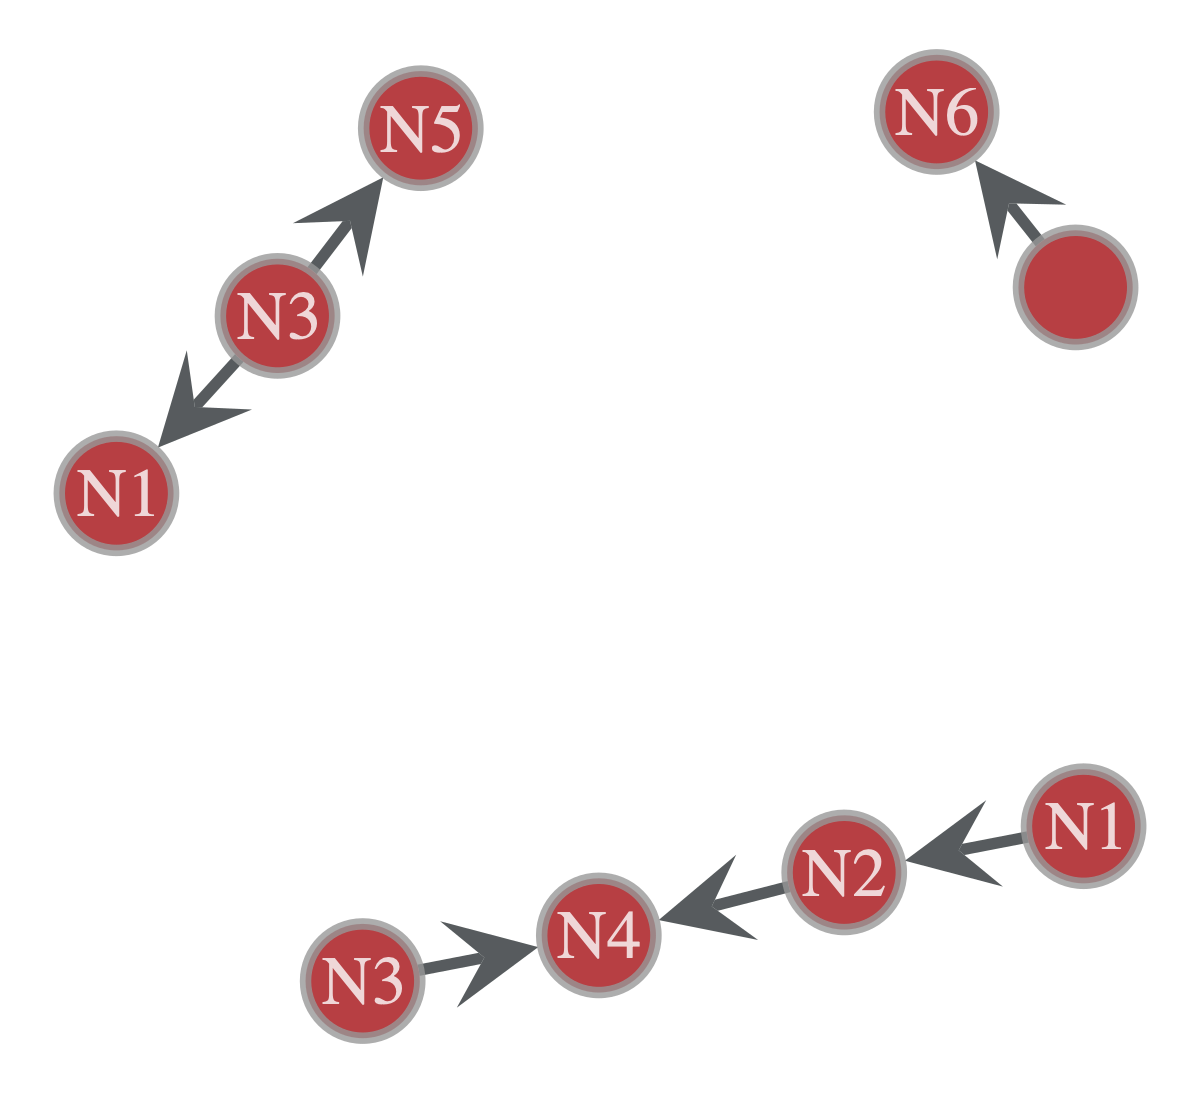

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x302a4b4a0, at 0x302a48dd0>

In [18]:
graph_draw(network0.graph, vertex_text=network0.graph.vp['node_id'])

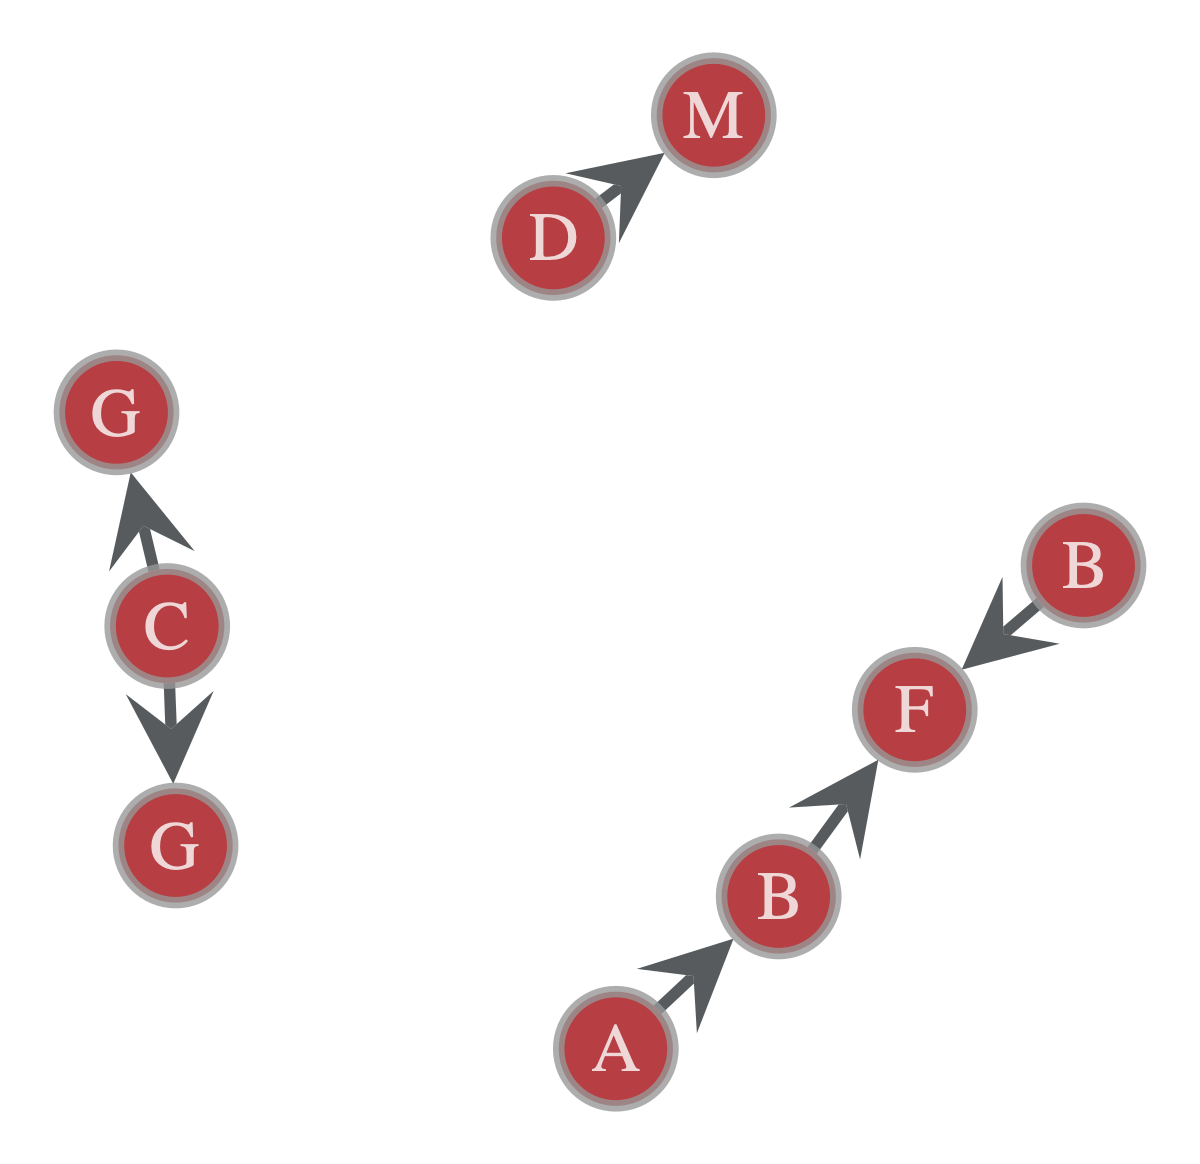

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x302a4b4a0, at 0x16e404ec0>

In [19]:
graph_draw(network0.graph, vertex_text=network0.graph.vp['prop1'])

In [22]:
data = {
    'Lipid class*': ['Class1|Class2', 'Class3', np.nan, 'Class4|Class5'],
    'Lipid ID': ['ID1|ID2', 'ID3', 'ID4', np.nan],
    'Source Attribute': ['High', 'Low', 'Medium', 'High'],
    'Target Attribute': ['Medium', 'High', 'Low', 'High'],
    'Weight': [1.5, 2.0, 1.2, 2.5],
    'Confidence': [0.95, 0.90, 0.85, 0.80]
}

df = pd.DataFrame(data)

In [23]:
# Initialize the network
network0 = MultilayerNetworkFast()

# Build the network using the wrapper method
network0.build_network_from_dataframe(
    df=df,
    from_node_id_col='Lipid class*',
    to_node_id_col='Lipid ID',
    from_node_property_cols=['Source Attribute'],
    to_node_property_cols=['Target Attribute'],
    edge_property_cols=['Weight', 'Confidence'],
    node_split_char='|',
    verbose=True
)

Building network from DataFrame...
Adding nodes to the graph...
Adding edges to the graph...
Network construction complete.


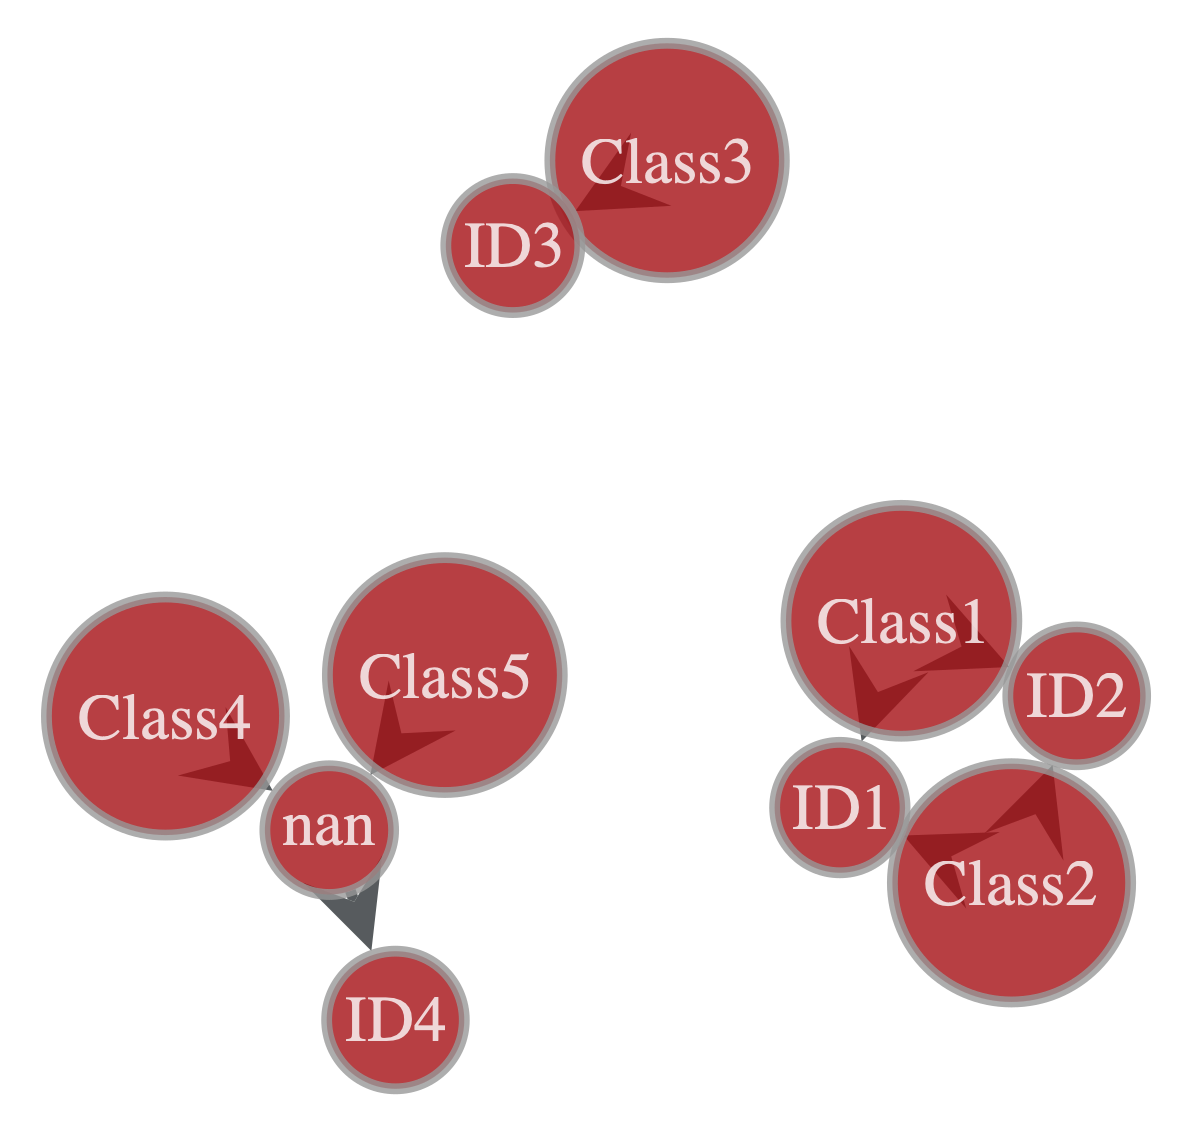

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3028b73b0, at 0x3029e6960>

In [25]:
graph_draw(network0.graph, vertex_text=network0.graph.vp['node_id'])

In [26]:
df_edges

,from_node_id,from_layer,from_prop1,to_node_id,to_layer,to_prop1,edge_prop1
0,N1,Layer1,A,N2,Layer1,E,0.1
1,N2|N3,Layer1,B,N4,Layer1,F,0.2
2,N3,Layer2,C,N5|N1,Layer3,G,0.3
3,,Layer3,D,N6,Layer2,M,0.4


In [20]:
# Initialize the network
network0 = MultilayerNetworkFast()

# Define which columns are edge properties and node properties
edge_property_cols = [f'EdgeProp{i}' for i in range(1, NUM_EDGE_PROPERTIES + 1)]
from_node_property_cols = [f'SourceProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]
to_node_property_cols = [f'TargetProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]

# Add edges from the DataFrame
network0.add_edges_from_dataframe(
    df=df_edges,
    from_node_id_col='from_col',
    to_node_id_col='to_col',
    from_layer_col='from_layer_col',
    to_layer_col='to_layer_col',
    edge_property_cols=edge_property_cols,
    from_node_property_cols=from_node_property_cols,
    to_node_property_cols=to_node_property_cols,
    split_char=SPLIT_CHAR,
    create_missing=True,
    skip_if_duplicate='exact',
    verbose=False,
    edge_property_mode='per-row'  # Choose 'per-edge' or 'per-row' based on your preference
)

network0.graph

TypeError: MultilayerNetworkFast.add_edges_from_dataframe() got an unexpected keyword argument 'from_node_property_cols'

In [8]:
# Initialize the network
network1 = MultilayerNetwork()

# Define which columns are edge properties and node properties
edge_property_cols = [f'EdgeProp{i}' for i in range(1, NUM_EDGE_PROPERTIES + 1)]
from_node_property_cols = [f'SourceProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]
to_node_property_cols = [f'TargetProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]

# Add edges from the DataFrame
network1.add_edges_from_dataframe(
    df=df_edges,
    from_node_id_col='from_col',
    to_node_id_col='to_col',
    from_layer_col='from_layer_col',
    to_layer_col='to_layer_col',
    edge_property_cols=edge_property_cols,
    from_node_property_cols=from_node_property_cols,
    to_node_property_cols=to_node_property_cols,
    split_char=SPLIT_CHAR,
    create_missing=True,
    skip_if_duplicate='exact',
    verbose=False,
    edge_property_mode='per-row'  # Choose 'per-edge' or 'per-row' based on your preference
)

network1.graph

TypeError: 'NoneType' object does not support item assignment

In [9]:
network1.graph.properties

{('v',
  'node_id'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x152aec9e0>,
 ('v',
  'layer'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x152df55e0>,
 ('v',
  'SourceProp1'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x152d1d5e0>,
 ('v',
  'SourceProp2'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x30d053830>,
 ('v',
  'SourceProp3'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x30d052cf0>,
 ('v',
  'SourceProp4'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x30d0536e0>,
 ('v',
  'SourceProp5'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x30d0501d0>,
 ('v',
  'SourceProp6'): <VertexPropertyMap object with value type 'string', for Graph 0x152aee6f0, at 0x30d050cb0>,
 ('v',
  'SourceProp7'): <VertexPropertyMap object with value type 'string

Testing the refactored version

In [10]:
# Initialize the network
network2 = MultilayerNetworkGraphTool()

# Define which columns are edge properties and node properties
edge_property_cols = [f'EdgeProp{i}' for i in range(1, NUM_EDGE_PROPERTIES + 1)]
from_node_property_cols = [f'SourceProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]
to_node_property_cols = [f'TargetProp{i}' for i in range(1, NUM_NODE_PROPERTIES + 1)]

# Add edges from the DataFrame
network2.add_edges_from_dataframe(
    df=df_edges,
    from_col='from_col',
    to_col='to_col',
    #from_layer=None,  # Using from_layer_col for variable layers
    #to_layer=None,    # Using to_layer_col for variable layers
    from_layer_col='from_layer_col',
    to_layer_col='to_layer_col',
    edge_property_cols=edge_property_cols,
    # from_node_property_cols=from_node_property_cols,
    # to_node_property_cols=to_node_property_cols,
    split_char=SPLIT_CHAR,
    create_missing=True,
    skip_if_duplicate='exact',
    verbose=False,
    edge_property_mode='per-row'  # Choose 'per-edge' or 'per-row' based on your preference
)

network2.graph

Expanding the DataFrame to generate all edge combinations...
Filtering out invalid rows...
Adding 17993 unique nodes to the graph...
Added 17993 nodes to the graph.
Preparing to add 98723 edges...
Adding edges in bulk...
Added 98723 edges to the graph.
Assigning edge properties in bulk...
Assigned edge properties: ['EdgeProp1', 'EdgeProp2', 'EdgeProp3', 'EdgeProp4', 'EdgeProp5', 'EdgeProp6', 'EdgeProp7', 'EdgeProp8', 'EdgeProp9', 'EdgeProp10']
Edge addition complete.


<Graph object, directed, with 17993 vertices and 98723 edges, 12 internal vertex properties, 10 internal edge properties, at 0x30d5431a0>

In [11]:
network2.graph.properties

{('v',
  'node_id'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x30d543110>,
 ('v',
  'layer'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x30d542ea0>,
 ('v',
  'Prop1'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309bc7d10>,
 ('v',
  'Prop2'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309a71640>,
 ('v',
  'Prop3'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309a1e570>,
 ('v',
  'Prop4'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309c6dac0>,
 ('v',
  'Prop5'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309c6ee40>,
 ('v',
  'Prop6'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309977170>,
 ('v',
  'Prop7'): <VertexPropertyMap object with value type 'string', for Graph 0x30d5431a0, at 0x309976ae0>,

In [12]:
# network.graph.save('scaleup_test4.gt')

In [13]:
# Check the number of edges
print(f"Total edges in the graph: {network.graph.num_edges()}")

# # Optionally, verify with the expected number
# expected_edges = 1164523
# actual_edges = network.graph.num_edges()
# if actual_edges == expected_edges:
#     print("All edges have been successfully added.")
# else:
#     print(f"Discrepancy in edge count: Expected {expected_edges}, but found {actual_edges}.")

NameError: name 'network' is not defined

In [12]:
df_edges

,from_col,to_col,from_layer_col,to_layer_col,EdgeProp1,EdgeProp2,EdgeProp3,EdgeProp4,EdgeProp5,EdgeProp6,...,TargetProp1,TargetProp2,TargetProp3,TargetProp4,TargetProp5,TargetProp6,TargetProp7,TargetProp8,TargetProp9,TargetProp10
0,N2008|,N5739|,Mixed,Mixed,0.642210,0.608540,0.166753,0.128571,0.116469,0.081732,...,TargetProp1_Value_7,TargetProp2_Value_8,TargetProp3_Value_14,TargetProp4_Value_19,TargetProp5_Value_12,TargetProp6_Value_12,TargetProp7_Value_20,TargetProp8_Value_9,TargetProp9_Value_1,TargetProp10_Value_15
1,N9926,N1592,Layer4,Layer5,0.353766,0.374078,0.383504,0.388991,0.767415,0.073769,...,TargetProp1_Value_19,TargetProp2_Value_6,TargetProp3_Value_14,TargetProp4_Value_1,TargetProp5_Value_13,TargetProp6_Value_10,TargetProp7_Value_17,TargetProp8_Value_17,TargetProp9_Value_16,TargetProp10_Value_18
2,N6999,N1218,Layer5,Layer5,0.387303,0.698015,0.825043,0.169276,0.984726,0.280359,...,TargetProp1_Value_14,TargetProp2_Value_13,TargetProp3_Value_19,TargetProp4_Value_11,TargetProp5_Value_15,TargetProp6_Value_17,TargetProp7_Value_11,TargetProp8_Value_2,TargetProp9_Value_6,TargetProp10_Value_16
3,N8617,N9917,Layer2,Layer1,0.389957,0.210509,0.673061,0.007896,0.967494,0.652057,...,TargetProp1_Value_4,TargetProp2_Value_4,TargetProp3_Value_2,TargetProp4_Value_12,TargetProp5_Value_16,TargetProp6_Value_10,TargetProp7_Value_13,TargetProp8_Value_10,TargetProp9_Value_7,TargetProp10_Value_6
4,N141,N4469,Layer1,Layer5,0.148176,0.724258,0.908598,0.011223,0.508040,0.367577,...,TargetProp1_Value_6,TargetProp2_Value_17,TargetProp3_Value_14,TargetProp4_Value_15,TargetProp5_Value_9,TargetProp6_Value_1,TargetProp7_Value_15,TargetProp8_Value_6,TargetProp9_Value_12,TargetProp10_Value_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,N3166,N3698,Layer4,Layer4,0.173668,0.544386,0.460268,0.035957,0.330145,0.680692,...,TargetProp1_Value_10,TargetProp2_Value_19,TargetProp3_Value_7,TargetProp4_Value_7,TargetProp5_Value_8,TargetProp6_Value_4,TargetProp7_Value_17,TargetProp8_Value_6,TargetProp9_Value_1,TargetProp10_Value_14
99996,N5819,N6769,Layer1,Layer4,0.784806,0.415819,0.459660,0.897704,0.984672,0.633070,...,TargetProp1_Value_17,TargetProp2_Value_9,TargetProp3_Value_15,TargetProp4_Value_10,TargetProp5_Value_6,TargetProp6_Value_2,TargetProp7_Value_18,TargetProp8_Value_19,TargetProp9_Value_9,TargetProp10_Value_9
99997,N8386,N8337,Layer4,Layer5,0.409093,0.881919,0.964504,0.078522,0.677551,0.770788,...,TargetProp1_Value_16,TargetProp2_Value_13,TargetProp3_Value_17,TargetProp4_Value_1,TargetProp5_Value_6,TargetProp6_Value_16,TargetProp7_Value_1,TargetProp8_Value_19,TargetProp9_Value_2,TargetProp10_Value_18
99998,NaN,N1319,Layer3,Layer4,0.017201,0.637884,0.400273,0.952243,0.125135,0.068930,...,TargetProp1_Value_16,TargetProp2_Value_1,TargetProp3_Value_3,TargetProp4_Value_15,TargetProp5_Value_17,TargetProp6_Value_17,TargetProp7_Value_12,TargetProp8_Value_10,TargetProp9_Value_15,TargetProp10_Value_18


In [13]:
network.node_map

{('Mixed', 'N2008'): <Vertex object with index '0' at 0x175858040>,
 ('Layer4', 'N9926'): <Vertex object with index '1' at 0x30babc240>,
 ('Layer5', 'N6999'): <Vertex object with index '2' at 0x30babc2c0>,
 ('Layer2', 'N8617'): <Vertex object with index '3' at 0x30babc340>,
 ('Layer1', 'N141'): <Vertex object with index '4' at 0x30babc3c0>,
 ('Layer3', 'N6037'): <Vertex object with index '5' at 0x30babc440>,
 ('Layer3', 'N8826'): <Vertex object with index '6' at 0x30babc4c0>,
 ('Layer3', 'N2076'): <Vertex object with index '7' at 0x30babc540>,
 ('Layer1', 'N3230'): <Vertex object with index '8' at 0x30babc5c0>,
 ('Layer3', 'N262'): <Vertex object with index '9' at 0x30babc640>,
 ('Layer4', 'N4334'): <Vertex object with index '10' at 0x30babc6c0>,
 ('Layer4', 'N9135'): <Vertex object with index '11' at 0x30babc740>,
 ('Layer4', 'N5441'): <Vertex object with index '12' at 0x30babc7c0>,
 ('Mixed', 'N2571'): <Vertex object with index '13' at 0x30babc840>,
 ('Layer4', 'N2814'): <Vertex obje